# Smoothness Analysis

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap

/Users/olyssa/opt/anaconda3/envs/vae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import data
adata = sc.read_h5ad("/Users/olyssa/PycharmProjects/VAE_embeddings/PBMC_adata.h5ad")

# Define embedding space
embedding_data = adata.obsm["embedding"]

# Define original space
original_data = adata.layers["counts"].toarray()

atac = adata.obsm["ATAC"].toarray()
original_data_atac = np.concatenate((original_data, atac), axis=1)

## Local Smoothness: Mean Neighborhood Variance

In [4]:
from sklearn.neighbors import NearestNeighbors

def compute_local_smoothness(Z, k=5):
    """
    Compute local smoothness by measuring variance in the k-nearest neighbors.
    """
    nbrs = NearestNeighbors(n_neighbors=k).fit(Z)
    distances, indices = nbrs.kneighbors(Z)
    
    smoothness_values = np.mean(distances[:, 1:]**2, axis=1)  # Ignore self-distance (first column)
    return smoothness_values

smoothness_values_local = compute_local_smoothness(embedding_data, k=5)

In [5]:
# Convert to DataFrame for easy plotting

# Apply UMAP to reduce to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(embedding_data)

df = pd.DataFrame({
    "UMAP_1": embeddings_2d[:, 0],
    "UMAP_2": embeddings_2d[:, 1],
    "Smoothness": smoothness_values_local
})

/Users/olyssa/opt/anaconda3/envs/vae/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


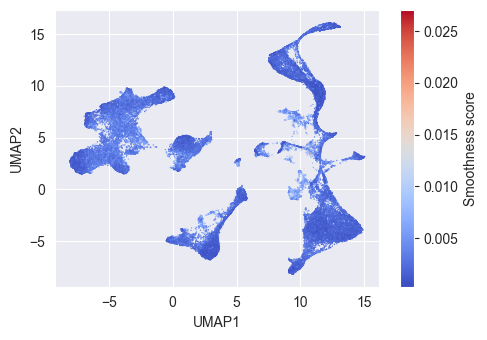

In [6]:
# Plot UMAP with smoothness values
fig, ax = plt.subplots(figsize=(5, 3.5))
sc = ax.scatter(df["UMAP_1"], df["UMAP_2"], c=smoothness_values_local, cmap="coolwarm", s=1, linewidth=0)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Smoothness score")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
fig.tight_layout()
fig.savefig('local_smoothness_UMAP.png', dpi=200)
plt.show()

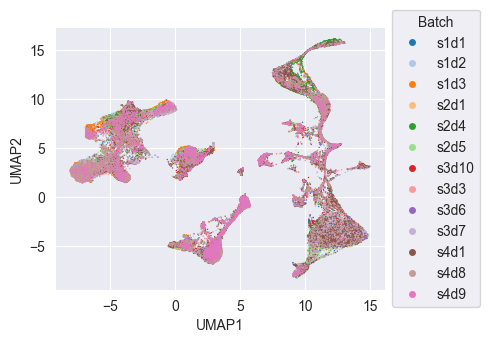

In [7]:
# Plot UMAP colored by "batch"

categories_batch = adata.obs["batch"].tolist()

fig, ax = plt.subplots(figsize=(5, 3.5))
sns.scatterplot(data=df, x="UMAP_1", y="UMAP_2", hue=categories_batch, palette="tab20", s=1, linewidth=0)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=5, title="Batch")
fig.tight_layout()
fig.savefig('batch_UMAP.png', dpi=200)
plt.show()

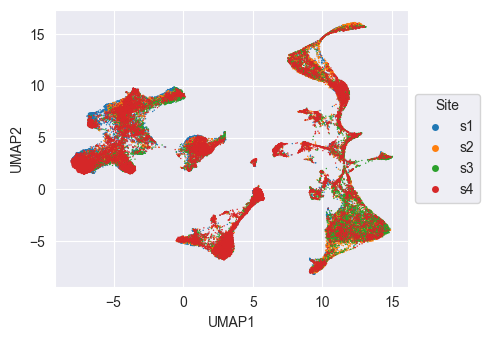

In [8]:
# Plot UMAP colored by "site"

categories_site = adata.obs["site"].tolist()

fig, ax = plt.subplots(figsize=(5, 3.5))
sns.scatterplot(data=df, x="UMAP_1", y="UMAP_2", hue=categories_site, palette="tab10", s=1, linewidth=0)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=5, title="Site")
fig.tight_layout()
fig.savefig('site_UMAP.png', dpi=200)
plt.show()

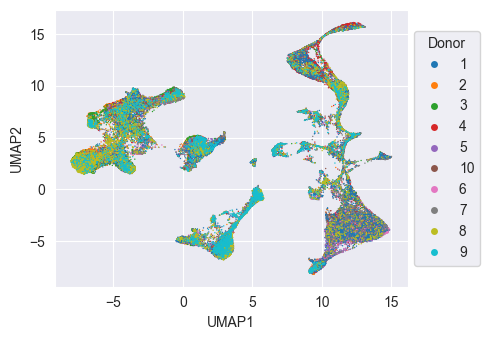

In [9]:
# Plot UMAP colored by "donor"

categories_donor = adata.obs["donor"].tolist()

fig, ax = plt.subplots(figsize=(5, 3.5))
sns.scatterplot(data=df, x="UMAP_1", y="UMAP_2", hue=categories_donor, palette="tab10", s=1, linewidth=0)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=5, title="Donor")
fig.tight_layout()
fig.savefig('donor_UMAP.png', dpi=200)
plt.show()

## Global Smoothness: Average Pairwise Distance

In [10]:
def compute_global_smoothness(Z):
    """
    Compute the global smoothness of the embedding space.
    """
    N = Z.shape[0]
    total_variance = 0
    for i in range(N):
        for j in range(i + 1, N):
            total_variance += np.linalg.norm(Z[i] - Z[j])**2

    return total_variance / (N * (N - 1))

#smoothness_value_global = compute_global_smoothness(embedding_data)

In [14]:
smoothness_value_global = pd.read_csv("smoothness_constant_global_all.csv").values[0][0]

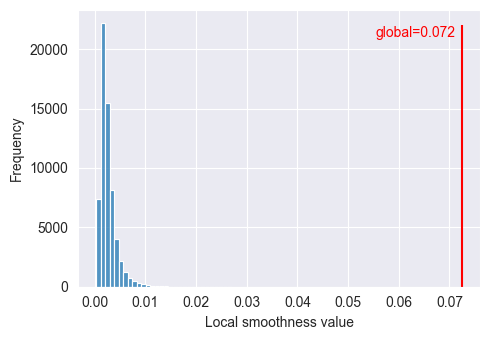

Local smoothness distribution: 0.003 ± 0.002


In [16]:
# Visualization
fig, axes = plt.subplots(figsize=(5, 3.5))
sns.histplot(smoothness_values_local, bins=30, kde=False)
plt.vlines(x=smoothness_value_global, ymin=0, ymax=22000, color="red")
plt.text(x=smoothness_value_global-0.017, y=21000, s=f"global={smoothness_value_global.round(3)}", color="red")
plt.xlabel("Local smoothness value")
plt.ylabel("Frequency")
#plt.title("Local smoothness distribution of embedding space")
fig.tight_layout()
fig.savefig('local_smoothness_distribution.png', dpi=200)
plt.show()
print("Local smoothness distribution:", smoothness_values_local.mean().round(3), "±", np.std(smoothness_values_local).round(3))